In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import warnings

In [3]:
# Load data
I_data_noisy = pd.read_excel('/content/real data.xlsx')['Total Cases (Weekly)'].values

# Check for NaNs or Infs in data
if np.any(np.isnan(I_data_noisy)) or np.any(np.isinf(I_data_noisy)):
    print("Detected NaN or Inf values in the infected data. Cleaning data...")

    # Clean the data
    # Set non-finite to NaN and drop NaNs
    I_data_noisy = np.where(np.isfinite(I_data_noisy), I_data_noisy, np.nan)
    I_data_noisy = pd.Series(I_data_noisy).dropna().values

    if I_data_noisy.size == 0:
        raise ValueError("Infected data is empty after cleaning. Please check your input file.")
else:
    print("No NaN or Inf values detected in the infected data.")

No NaN or Inf values detected in the infected data.


In [6]:
# Train test split
hor = 12 # Forecast horizon
train_length = len(I_data_noisy)-12

In [12]:
I_data_noisy = I_data_noisy[0:train_length]

In [14]:
# Determine initial conditions
initial_infected = I_data_noisy[0]
initial_total_population = 180000
y0 = [
    initial_total_population - initial_infected,  # S0
    initial_infected,  # I0
    0,  # B0
    0   # R0
]

# Simulate time points based on the data length
t_data =  np.linspace(0, len(I_data_noisy)+hor - 1, len(I_data_noisy)+hor)
t_data_1 = np.linspace(0, len(I_data_noisy) - 1, len(I_data_noisy))

In [15]:
t_data

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71.])

In [16]:
# Define the system of ODEs
def model(y, t, alpha1, tau, omega, sigma_e, k_1, sigma_h, phi_0, phi_1, bed, gamma, beta, delta,):
    S, I, B, R = y
    dSdt = (alpha1 * (S + I + R) + tau * R - alpha1 * S - (1 - omega) * (sigma_e * B / (k_1 + B) + sigma_h * I) * S)
    dIdt = ((1 - omega) * (sigma_e * B / (k_1 + B)) * S + (1 - omega) * sigma_h * I * S -
             (phi_0 + (phi_1 - phi_0) * bed / (I + bed)) * I - alpha1 * I)
    dBdt = (gamma * B * (1 - B / 10**(5)) + 10 * I - (beta + delta) * B)
    dRdt = ((phi_0 + (phi_1 - phi_0) * bed / (I + bed)) * I - (tau + alpha1) * R)
    return [dSdt, dIdt, dBdt, dRdt]

# Define the function for curve fitting
def fit_model(t, alpha, tau, omega, sigma_e, k_1, sigma_h, phi_0, phi_1, bed, gamma, beta, delta):
    # Use odeint to integrate the model
    y = odeint(model, y0, t, args=(alpha, tau, omega, sigma_e, k_1, sigma_h, phi_0, phi_1, bed, gamma, beta, delta))
    return y[:, 1]  # Return the I values


In [17]:
# Set bounds for parameters
bounds = (
        [0, 0, 0, 0, 1e4, 0, 0, 0, 0, 0, 0, 1],  # lower bounds
        [1, 1, 1, 1, 1e7, 1, 1, 1, 100, 10, 1, 100]  # upper bounds
)

    # Initial guess for the parameters
true_params = [0.223, 0.5, 0.87, 0.0788, 10**5, 1.36 * 10**(-5), 0.015, 0.09, 10, 2, 1/30, 4]

# Fitting the model to the data
popt, pcov = curve_fit(fit_model, t_data_1, I_data_noisy, p0=true_params, bounds=bounds, method='trf')
fitted_params = popt
perr = np.sqrt(np.diag(pcov))  # Standard deviations of the parameters

In [19]:
# Solve the ODE with fitted parameters
y_fit = odeint(model, y0, t_data, args=tuple(fitted_params))
I_fit = y_fit[:, 1]  # Getting the infected data

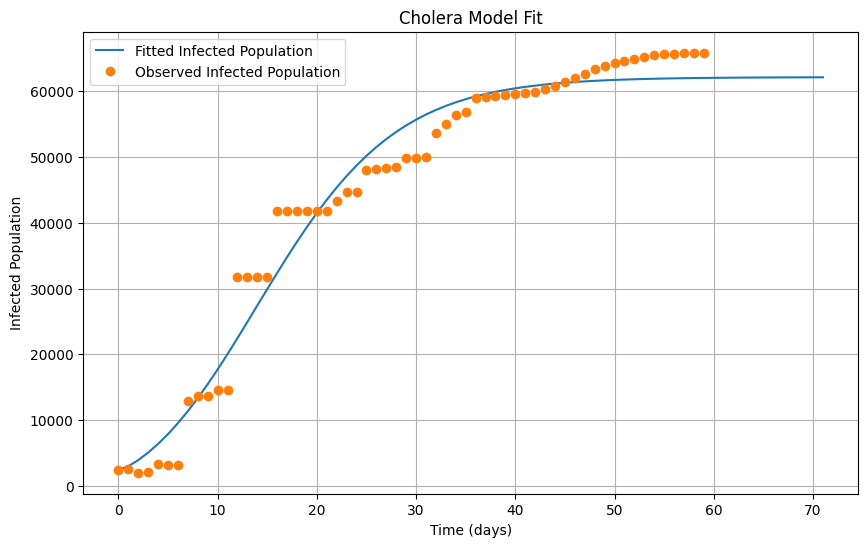

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(t_data, I_fit, label='Fitted Infected Population')
plt.plot(t_data_1, I_data_noisy, 'o', label='Observed Infected Population')  # Plot the observed data as points
plt.xlabel('Time (days)')
plt.ylabel('Infected Population')
plt.title('Cholera Model Fit')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
df_fit = pd.DataFrame({'Time': t_data, 'Fitted Infected Population': I_fit})
df_fit.to_excel('SIBR_model_fit.xlsx', index=False)